In [25]:
import pandas as pd
import numpy as np
import itertools as it
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

# Preliminaries, make variables for plotting and labels

In [26]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
month_abbrev = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
                '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-08-01'

alldates = pd.date_range(start=start, end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values, list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

# Load data from google sheets
https://docs.google.com/spreadsheets/d/1YJt62E16PZkIl2ZPTUhm2fFVdRT6BKidswFKT6aIZsk/edit?usp=sharing

In [27]:
# # get school names, abbreviations, colors, etc.
# school_deets = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
#                            '1YJt62E16PZkIl2ZPTUhm2fFVdRT6BKidswFKT6aIZsk/gviz/tq?tqx=out:csv&sheet=refs')
school_deets = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                           '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=refs')

In [28]:
# names of all the tabs in the google sheet
# blist = ['167358','164988','166027','164924','166683','165662','164739','168005','168148','166638','168227',
#          '166391','165015','164748','167783','165671','165529','166674']#,'166629']

blist = ['164748', '167057', '167358', '168227', '167783', '166674', '166683', '165671',
         '166656', '164988', '165662', '168005', '166027', '166638', '168148', '164924',
         '165644', '165529', '164739', '166391', '165015', '164580', '167598', '168218']

In [29]:
# span through each google sheet and append it to a single dataframe
bout = []
for b in blist:
    col = school_deets.loc[school_deets['ipeds_id']==int(b)]['name'].values[0]
    burl = col.replace(" ",'%20')
    boston_d = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                           '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=%s'%burl)
    boston_d = boston_d[['date','total_tests','positive_tests','college','url','ipeds_id']].copy()
    deets_d = school_deets.loc[school_deets['ipeds_id']==boston_d['ipeds_id'].values[0]].copy()

    boston_dx = DATE_DF.copy()
    boston_dx['university'] = boston_d['college'].dropna().unique()[0]
    boston_dx['enrollment'] = deets_d['enrollment'].dropna().unique()[0]
    boston_dx['url'] = boston_d['url'].dropna().unique()[0]
    boston_dx = boston_dx.merge(boston_d[['date','total_tests','positive_tests']],how='left',on='date')
    boston_dx['total_tests'] = np.nan_to_num(boston_dx['total_tests'])
    boston_dx['positive_tests'] = np.nan_to_num(boston_dx['positive_tests'])
    boston_dx['total_tests'] = boston_dx['total_tests'].astype(str).str.replace(',','').astype(float)
    boston_dx['total_tests'] = np.nan_to_num(boston_dx['total_tests'])
    boston_d = boston_dx.loc[(boston_dx['date']<=today)&(boston_dx['date']>=start)].copy()
    
    bout.append(boston_d)
    
boston_data = pd.concat(bout).reset_index().iloc[:,1:]
boston_g = boston_data.groupby(['week','university','enrollment']).agg({
                                'date':'min','total_tests':'sum','positive_tests':'sum'}).reset_index()

In [30]:
boston_data.to_csv('../data/boston_area_ihe_data.csv',index=False)

In [31]:
dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01',
            '2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

# Plot a big jumble of case counts over time

In [32]:
sorder = boston_data.groupby('university').agg({'positive_tests':'sum'}
                                            ).reset_index().sort_values('positive_tests',ascending=False)
sorder = sorder['university'].values[:24]

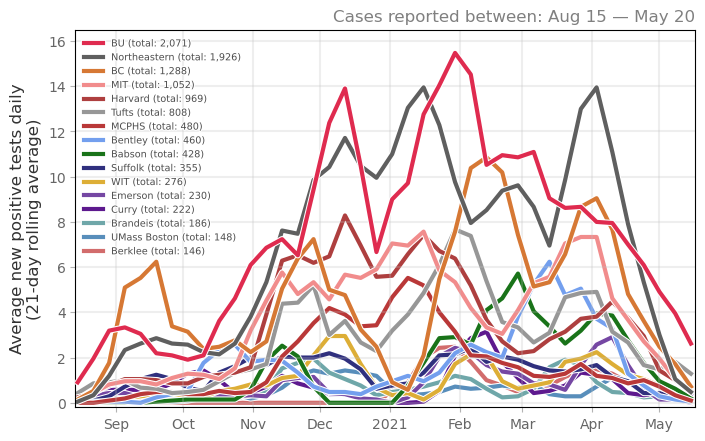

In [9]:
wid = 3
lw = 3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

for ui, univ in enumerate(sorder[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_data.loc[boston_data['university']==univ].copy()
    data_u = data_u.loc[data_u['date']>start].copy()
    data_u = data_u.groupby('week').agg({'positive_tests':np.nansum, 'date':'min'}).reset_index()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    totsum = sum(data_u['positive_tests'].values)
    yvalr_u = data_u['positive_tests'].rolling(window=wid).mean().values / 7

    ax.plot(xvals_u, yvalr_u, color=univ_col, linewidth=lw, alpha=0.9,
            label='%s (total: %s)'%(univ_abb,"{:,}".format(int(totsum))), zorder=wid-ui,
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'), path_effects.Normal()])

l = ax.legend(fontsize='x-small',framealpha=0,loc=2,ncol=1,labelspacing=0.4)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])
l.set_zorder(20)

ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll)

ax.set_ylim(-0.2,16.5)
ax.set_xlim(min(xvals_u)+12, max(xvals_u)+2)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')
ax.set_ylabel('Average new positive tests daily\n(%i-day rolling average)'%(wid*7), color='.2',fontsize='large')
ax.set_title("Cases reported between: %s — %s"%('Aug 15',
               month_abbrev[today[5:7]]+" "+today[8:]), x=1.0, ha='right', color='.5')

plt.savefig('../figs/pngs/university_w.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_w.pdf', bbox_inches='tight')

plt.show()

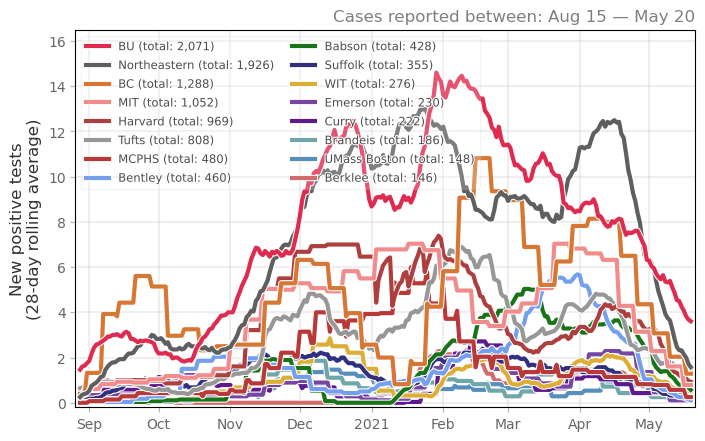

In [10]:
wid = 28
lw = 3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

for ui, univ in enumerate(sorder[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_data.loc[boston_data['university']==univ].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    totsum = sum(data_u['positive_tests'].values)
    yvals_u = data_u['positive_tests'].values
    yvalr_u = data_u['positive_tests'].rolling(window=wid).mean().values

    ax.plot(xvals_u[:-1], yvalr_u[:-1], color=univ_col, linewidth=lw, alpha=0.9,
            label='%s (total: %s)'%(univ_abb,"{:,}".format(int(totsum))), zorder=wid-ui,
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'), path_effects.Normal()])

l = ax.legend(fontsize='small',framealpha=0.2,loc=2,ncol=2,columnspacing=1.5)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])
l.set_zorder(30)

ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll)

ax.set_ylim(-0.2,16.5)
ax.set_xlim(date_dict['2020-08-26'], date_dict[today]+1)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')
ax.set_ylabel('New positive tests\n(%i-day rolling average)'%wid, color='.2',fontsize='large')
ax.set_title("Cases reported between: %s — %s"%('Aug 15',
               month_abbrev[today[5:7]]+" "+today[8:]), x=1.0, ha='right', color='.5')

plt.savefig('../figs/pngs/university.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university.pdf', bbox_inches='tight')

plt.show()

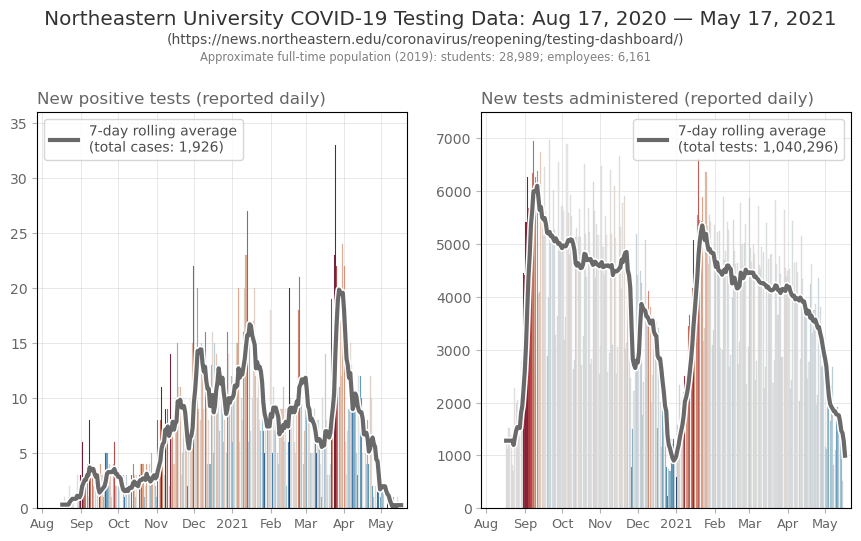

In [11]:
dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01',
            '2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

import matplotlib
fig, ax = plt.subplots(1,2,figsize=(10.5,5.25),dpi=100)
plt.subplots_adjust(wspace=0.2)
wid = 7
univ = 'Northeastern University'
num_students = 28989
num_employee = 6161
as_of_year = 2019
univ_col = '.35'
univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]
col_vars = ['positive_tests','total_tests']
lab_vars = ['cases','tests']

data_u = boston_data.loc[(boston_data['university']==univ)&\
                         (boston_data['date']<=DATERANGE[date_dict[today]-2])&\
                         (boston_data['date']>='2020-08-17')].copy()

if data_u[col_vars].sum(axis=1).values[-1]==0:
    data_u = boston_data.loc[(boston_data['university']==univ)&\
                             (boston_data['date']<=DATERANGE[date_dict[today]-3])&\
                             (boston_data['date']>='2020-08-17')].copy()    

xvals_u = np.array([date_dict[i] for i in data_u['date'].values])

for li,l in enumerate(col_vars):
    yvals_u = data_u[l].values
    yvalr_u = data_u[l].rolling(window=wid).mean().values
    yvalr_u[:wid-1] = np.mean(yvals_u[:wid-1])
    totsum = int(sum(data_u[l].values))# / np.nanmean(data_u['enrollment']) * 1000
    pct_diffs = np.nan_to_num(data_u[l].rolling(window=int(wid*2)).mean().pct_change().values)
    pct_diffs[pct_diffs>0.3] = 0.3
    norm = matplotlib.colors.Normalize(vmin=-0.15, vmax=0.15)
    cvals = norm(pct_diffs)
    col = plt.cm.RdBu_r(cvals)

    ax[li].bar(xvals_u, yvals_u, color='.5', width=0.85, lw=0)
    ax[li].bar(xvals_u, yvals_u, color=col, alpha=0.9, width=0.85, lw=0.1, ec='.6')
    ax[li].plot(xvals_u, yvalr_u, color=univ_col, linewidth=lw, alpha=0.9,
                label='%i-day rolling average\n(total %s: %s)'%(wid,lab_vars[li],"{:,}".format(int(totsum))),
                path_effects=[path_effects.Stroke(linewidth=lw*1.75, foreground='w'),
                              path_effects.Normal()])

ld = month_abbrev[data_u['date'].max()[5:7]]+" "+data_u['date'].max()[8:]
ax[0].set_title("New positive tests (reported daily)", x=0.0, ha='left', color='.4')
ax[1].set_title("New tests administered (reported daily)", x=0.0, ha='left', color='.4')
ax[0].set_ylim(0, 36)
ax[1].set_ylim(0, 7500)

ld = month_abbrev[data_u['date'].max()[5:7]]+" "+data_u['date'].max()[8:]
plt.suptitle('   Northeastern University COVID-19 Testing Data: Aug 17, 2020 — %s, 2021'%ld,
             fontsize='x-large',color='.2',y=1.075)
ax[0].text(1.05, 1.2, '(%s)'%data_u['url'].unique()[0],
           transform=ax[0].transAxes, ha='center', va='top',fontsize='medium',color='.3')
ax[0].text(1.05, 1.155, 'Approximate full-time population (%i): '%as_of_year+\
           'students: %s; employees: %s'%("{:,}".format(int(num_students)),"{:,}".format(int(num_employee))),
           transform=ax[0].transAxes, ha='center', va='top',fontsize='small',color='.5')


for a in fig.axes:
    l = a.legend(fontsize='medium')#,framealpha=0.2)
    for text in l.get_texts():
        text.set_color('.3')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                               path_effects.Normal()])
    l.set_zorder(20)
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll,fontsize=9.25)
    a.set_xlim(date_dict['2020-08-01']-4, date_dict[today]+2)
    a.grid(linewidth=0.5,color='.75',alpha=0.5)
    a.tick_params(labelcolor='.4',color='.7')

plt.savefig('../figs/pngs/northeastern.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/northeastern.pdf', bbox_inches='tight')

plt.show()

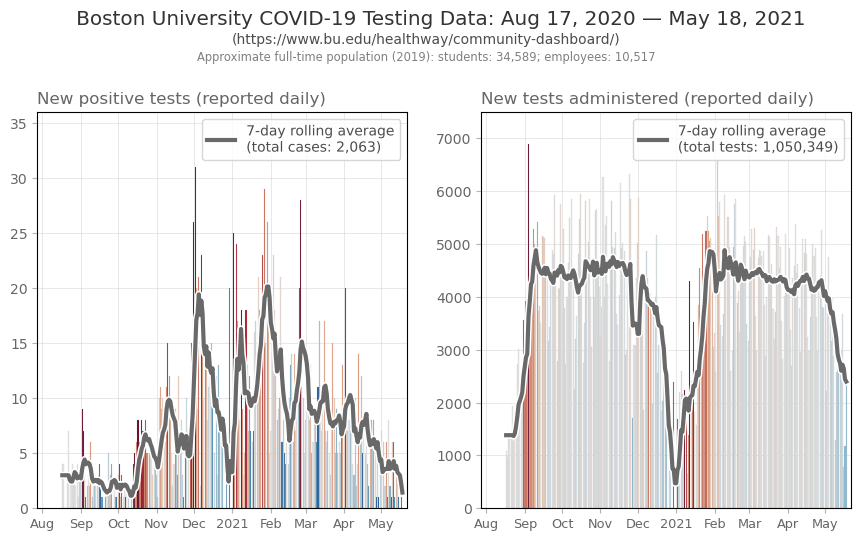

In [12]:
dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01','2021-01-01',
            '2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

import matplotlib
fig, ax = plt.subplots(1,2,figsize=(10.5,5.25),dpi=100)
plt.subplots_adjust(wspace=0.2)
wid = 7
univ = 'Boston University'
num_students = 34589
num_employee = 10517
as_of_year = 2019
univ_col = '.35'
univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]
col_vars = ['positive_tests','total_tests']
lab_vars = ['cases','tests']

data_u = boston_data.loc[(boston_data['university']==univ)&\
                         (boston_data['date']<=DATERANGE[date_dict[today]-2])&\
                         (boston_data['date']>='2020-08-17')].copy()

if data_u[col_vars].sum(axis=1).values[-1]==0:
    data_u = boston_data.loc[(boston_data['university']==univ)&\
                             (boston_data['date']<=DATERANGE[date_dict[today]-3])&\
                             (boston_data['date']>='2020-08-17')].copy()    

xvals_u = np.array([date_dict[i] for i in data_u['date'].values])

for li,l in enumerate(col_vars):
    yvals_u = data_u[l].values
    yvalr_u = data_u[l].rolling(window=wid).mean().values
    yvalr_u[:wid-1] = np.mean(yvals_u[:wid-1])
    totsum = int(sum(data_u[l].values))# / np.nanmean(data_u['enrollment']) * 1000
    pct_diffs = np.nan_to_num(data_u[l].rolling(window=int(wid*2)).mean().pct_change().values)
    pct_diffs[pct_diffs>0.3] = 0.3
    norm = matplotlib.colors.Normalize(vmin=-0.15, vmax=0.15)
    cvals = norm(pct_diffs)
    col = plt.cm.RdBu_r(cvals)

    ax[li].bar(xvals_u, yvals_u, color='.5', width=0.85, lw=0)
    ax[li].bar(xvals_u, yvals_u, color=col, alpha=0.9, width=0.85, lw=0.1, ec='.6')
    ax[li].plot(xvals_u, yvalr_u, color=univ_col, linewidth=lw, alpha=0.9,
                label='%i-day rolling average\n(total %s: %s)'%(wid,lab_vars[li],"{:,}".format(int(totsum))),
                path_effects=[path_effects.Stroke(linewidth=lw*1.75, foreground='w'),
                              path_effects.Normal()])

ld = month_abbrev[data_u['date'].max()[5:7]]+" "+data_u['date'].max()[8:]
ax[0].set_title("New positive tests (reported daily)", x=0.0, ha='left', color='.4')
ax[1].set_title("New tests administered (reported daily)", x=0.0, ha='left', color='.4')
ax[0].set_ylim(0, 36)
ax[1].set_ylim(0, 7500)

ld = month_abbrev[data_u['date'].max()[5:7]]+" "+data_u['date'].max()[8:]
plt.suptitle('   Boston University COVID-19 Testing Data: Aug 17, 2020 — %s, 2021'%ld,
             fontsize='x-large',color='.2',y=1.075)
ax[0].text(1.05, 1.2, '(%s)'%data_u['url'].unique()[0],
           transform=ax[0].transAxes, ha='center', va='top',fontsize='medium',color='.3')
ax[0].text(1.05, 1.155, 'Approximate full-time population (%i): '%as_of_year+\
           'students: %s; employees: %s'%("{:,}".format(int(num_students)),"{:,}".format(int(num_employee))),
           transform=ax[0].transAxes, ha='center', va='top',fontsize='small',color='.5')


for a in fig.axes:
    l = a.legend(fontsize='medium')#,framealpha=0.2)
    for text in l.get_texts():
        text.set_color('.3')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                               path_effects.Normal()])
    l.set_zorder(20)
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll,fontsize=9.25)
    a.set_xlim(date_dict['2020-08-01']-4, date_dict[today]+2)
    a.grid(linewidth=0.5,color='.75',alpha=0.5)
    a.tick_params(labelcolor='.4',color='.7')

plt.savefig('../figs/pngs/bostonuniversity.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/bostonuniversity.pdf', bbox_inches='tight')

plt.show()


# Same plot but with the "per 1000" corrections

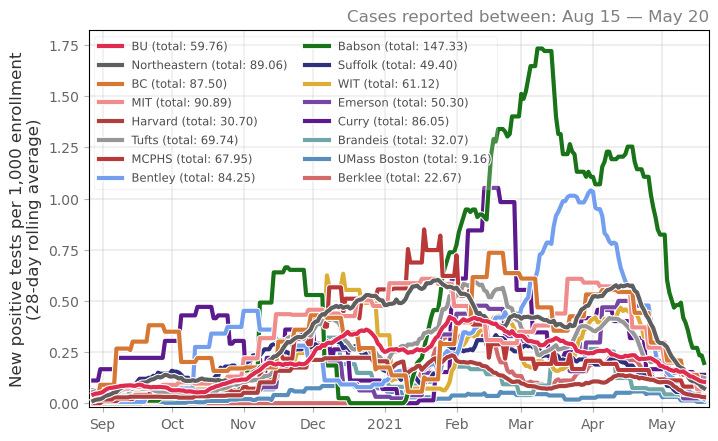

In [13]:
wid = 28
lw = 3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)

for ui, univ in enumerate(sorder[:16]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_data.loc[boston_data['university']==univ].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    yvals_u = data_u['positive_tests'].values
    yvalr_u = data_u['positive_tests'].rolling(window=wid).mean().values
    yvalr_u_per = yvalr_u / np.nanmean(data_u['enrollment']) * 1000
    totsum = sum(data_u['positive_tests'].values) / np.nanmean(data_u['enrollment']) * 1000
    
    ax.plot(xvals_u[:-1], yvalr_u_per[:-1], color=univ_col, linewidth=lw, alpha=0.9,
            label='%s (total: %.2f)'%(univ_abb,totsum), zorder=wid-ui,
            path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'), path_effects.Normal()])
            

l = ax.legend(fontsize='small',framealpha=0.2,loc=2,ncol=2,columnspacing=1.5)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])
l.set_zorder(20)

ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll)
ax.set_ylim(-0.02,1.825)
ax.set_xlim(date_dict['2020-08-26'], date_dict[today]+1)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')
ax.set_ylabel('New positive tests per 1,000 enrollment\n(%i-day rolling average)'%wid,
              color='.2',fontsize='large')
ax.set_title("Cases reported between: %s — %s"%('Aug 15',
               month_abbrev[today[5:7]]+" "+today[8:]), x=1.0, ha='right', color='.5')

plt.savefig('../figs/pngs/university_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_per_1000.pdf', bbox_inches='tight')

plt.show()

# Grid of weekly sums of case counts

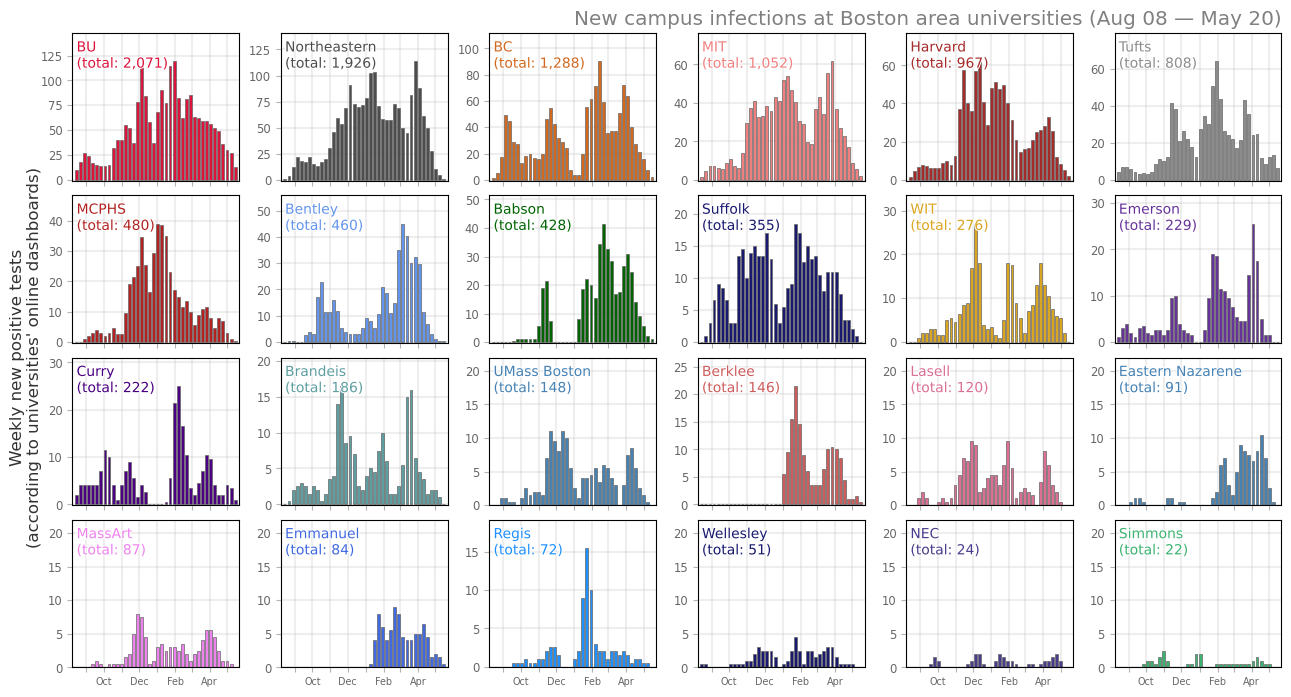

In [14]:
w = 2.6; h = 2.1
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.1)

for i, univ in enumerate(sorder):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_g.loc[(boston_g['university']==univ)&(boston_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
#     yvals_u = data_u['positive_tests'].values+1
    yvals_u = data_u['positive_tests'].rolling(window=2).mean().values
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.4', lw=0.5, width=5)

    name = univ_abb + '\n(total: %s)'%("{:,}".format(tot_cases))
    text = ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                                   path_effects.Normal()])
    if np.nanmax(yvals_u) < 15: 
        ax[tups[i]].set_ylim(0, 22)
    else:
        ylim_st = ax[tups[i]].get_ylim()
        ylim_st = (0, np.nanmax(yvals_u)*1.24)
        ydiff = ylim_st[1] - ylim_st[0]
        ax[tups[i]].set_ylim(0-ydiff*0.005, ylim_st[1])
        
ax[(2,0)].set_ylabel("Weekly new positive tests\n(according to universities' online dashboards)",
                     color='.2',fontsize='large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Boston area universities (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5',fontsize='x-large')

for a in fig.axes:
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels([i if ix%2==0 else '' for ix, i in enumerate(dates_ll)],fontsize='x-small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.set_xlim(date_dict['2020-08-08'], date_dict[today]+2)


plt.savefig('../figs/pngs/university_boston_grid_raw.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_boston_grid_raw.pdf', bbox_inches='tight')

plt.show()

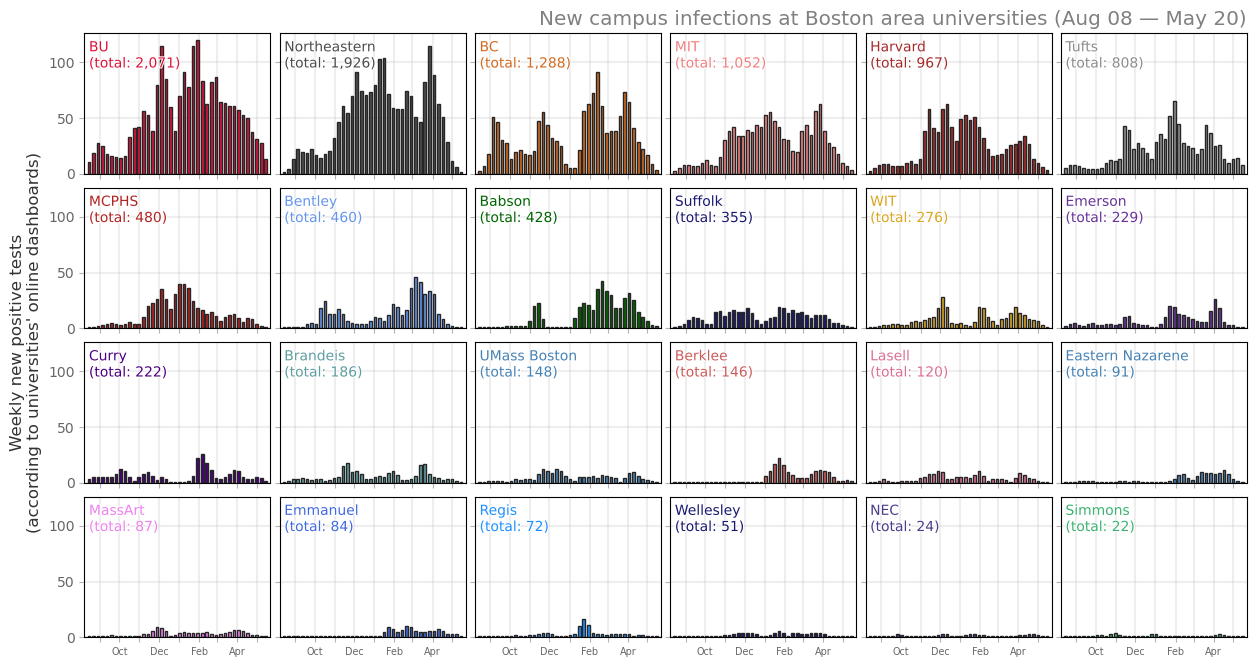

In [15]:
w = 2.5; h = 2.0
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(sorder):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_g.loc[(boston_g['university']==univ)&(boston_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].rolling(window=2).mean().values + 1
    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)

    name = univ_abb + '\n(total: %s)'%("{:,}".format(tot_cases))
    text = ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

ax[(2,0)].set_ylabel("Weekly new positive tests\n(according to universities' online dashboards)",
                     color='.2',fontsize='large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Boston area universities (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5',fontsize='x-large')

for a in fig.axes:
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels([i if ix%2==0 else '' for ix, i in enumerate(dates_ll)],fontsize='x-small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict['2020-08-08'], date_dict[today]+2)


plt.savefig('../figs/pngs/university_boston_grid.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_boston_grid.pdf', bbox_inches='tight')

plt.show()

# Same plot but with the "per 1000" corrections

In [16]:
sorder = boston_g.groupby('university').agg({'positive_tests':'sum','enrollment':'mean'}).reset_index()
sorder['positive_tests_per'] = sorder['positive_tests'] / sorder['enrollment'] * 1000
sorder = sorder.sort_values('positive_tests_per',ascending=False)['university'].values[:64]

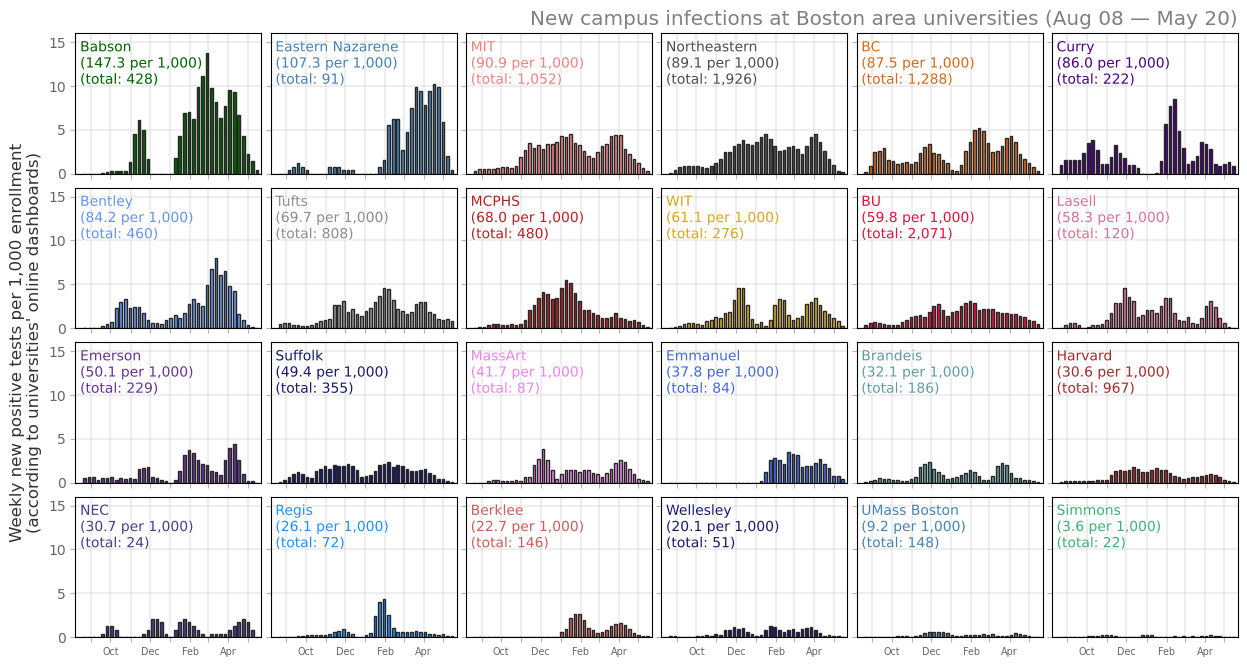

In [17]:
w = 2.5; h = 2.0
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05,hspace=0.1)

for i, univ in enumerate(sorder[:len(tups)]):
    univ_col = school_deets.loc[school_deets['name']==univ,'color'].values[0]
    univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]

    data_u = boston_g.loc[(boston_g['university']==univ)&(boston_g['date']>start)].copy()
    xvals_u = np.array([date_dict[i] for i in data_u['date'].values])
    tot_cases = int(sum(data_u['positive_tests'].values))
    yvals_u = data_u['positive_tests'].rolling(window=3).mean().values
    yvals_u = yvals_u / data_u['enrollment'] * 1000
    tot_cases_per = tot_cases / data_u['enrollment'].values[0] * 1000

    ax[tups[i]].bar(xvals_u, yvals_u, fc=univ_col, ec='.15', lw=1, width=4)
    name = univ_abb + '\n(%.1f per 1,000)\n(total: %s)'%(tot_cases_per,"{:,}".format(tot_cases))

    text = ax[tups[i]].text(0.025, 0.95, name, transform=ax[tups[i]].transAxes,
                     color=univ_col, ha='left', va='top', fontsize='medium',
                     path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

ax[(2,0)].set_ylabel("Weekly new positive tests per 1,000 enrollment\n"+\
                     "(according to universities' online dashboards)",
                     color='.2',fontsize='large', y=1)
ax[(0,ncols-1)].set_title("New campus infections at Boston area universities (%s — %s)"%(
                          month_abbrev[data_u['date'].min()[5:7]]+" "+data_u['date'].min()[8:],
                          month_abbrev[today[5:7]]+" "+today[8:]),
                    x=1.0, ha='right', color='.5',fontsize='x-large')

for a in fig.axes:
    a.set_ylim(0, 16)
    a.set_yticks(np.arange(0,20,5))
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels([i if ix%2==0 else '' for ix, i in enumerate(dates_ll)],fontsize='x-small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7')
    a.set_xlim(date_dict['2020-08-08'], date_dict[today]+2)


plt.savefig('../figs/pngs/university_boston_grid_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_boston_grid_per_1000.pdf', bbox_inches='tight')

plt.show()

# Compare higher education cases with cases in the surrounding counties

In [18]:
data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
ll = pd.read_csv(data_url, delimiter=',', dtype={'fips':str, 'cases':float, 'deaths':float})

ll = ll.loc[(ll['fips'].isin(['25025','25021','25017']))&(ll['date']>start)].copy()
ll = ll.sort_values(['county','date'])

state_df = []
for st in ll.fips.unique():
    ll_st = ll.loc[ll['fips']==st].copy()

    ll_st['new_deaths'] = list(np.nan_to_num(ll_st['deaths'].diff().tolist()).astype(int))
    ll_st['new_cases'] = list(np.nan_to_num(ll_st['cases'].diff().tolist()).astype(int))

    ll_st.loc[ll_st['new_cases']<0,'new_cases'] = 0
    ll_st.loc[ll_st['new_deaths']<0,'new_deaths'] = 0
    state_df.append(ll_st)

ll = pd.concat(state_df).sort_values(['date','state']).reset_index().iloc[:,1:]
ll = ll.sort_values(['county','date'])
ll = ll.dropna().reset_index().iloc[:,1:]

In [19]:
boston_data = boston_data.loc[boston_data['university']!='University of Massachusetts-Amherst'].copy()

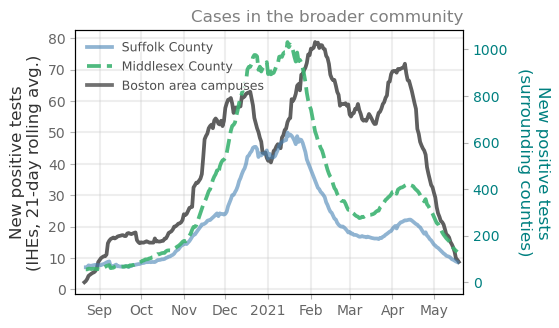

In [20]:
wid = 21
fig, ax = plt.subplots(1,1,figsize=(5,3.5),dpi=100)

sch_df = boston_data.groupby('date').agg({'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

ax.plot([date_dict[i] for i in bosdates[:-1]], allbost[:-1], label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)

ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll)
ax.set_xlim(date_dict['2020-08-15']-0.5, date_dict[today]+2)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')

ax.set_ylabel('New positive tests\n(IHEs, %i-day rolling avg.)'%wid,
                 color='.2',fontsize='large')

ax.set_title("Cases in the broader community", x=1.0, ha='right', color='.5')

ax2 = ax.twinx()

suffx = [date_dict[i] for i in ll.loc[ll['fips']=='25025']['date'].values]
suffy = ll.loc[ll['fips']=='25025']['new_cases'].rolling(window=wid).mean().values
ax2.plot(suffx[:-1], suffy[:-1], label='Suffolk County', color='steelblue', lw=lw*0.9, alpha=0.6)

middx = [date_dict[i] for i in ll.loc[ll['fips']=='25017']['date'].values]
middy = ll.loc[ll['fips']=='25017']['new_cases'].rolling(window=wid).mean().values
ax2.plot(middx[:-1], middy[:-1], label='Middlesex County', color='mediumseagreen',
         linestyle='--', lw=lw*0.9, alpha=0.9)
ax2.plot([0,0], [0,0], label='Boston area campuses', color='.3', lw=lw*0.9, alpha=0.8)

ax2.set_ylabel('New positive tests\n(surrounding counties)',
                 color='teal',fontsize='large',labelpad=30,rotation=270)
ax2.tick_params(axis='y', labelcolor='teal',color='.7')

l = ax2.legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_rawcases.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_rawcases.pdf', bbox_inches='tight')
plt.show()

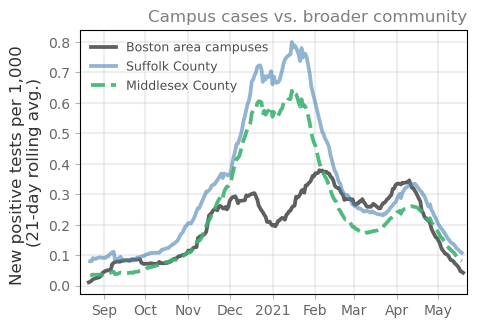

In [21]:
suffolk_population = 803907
middlesex_population = 1611699

wid = 21
fig, ax = plt.subplots(1,1,figsize=(5,3.5),dpi=100)

sch_df = boston_data.groupby('date').agg({'positive_tests':np.nansum,
                                          'enrollment':np.nansum}).reset_index()
sch_df['positive_tests_per_1000'] = (sch_df['positive_tests'] / sch_df['enrollment']) * 1000
allbost = sch_df['positive_tests_per_1000'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

ax.plot([date_dict[i] for i in bosdates[:-1]], allbost[:-1], label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)

ax.set_xticks([date_dict[i] for i in dates_tt])
ax.set_xticklabels(dates_ll)
ax.set_xlim(date_dict['2020-08-15']-0.5, date_dict[today]+2)
ax.grid(linewidth=1.5,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.4',color='.7')

ax.set_ylabel('New positive tests per 1,000 \n(%i-day rolling avg.)'%wid,
                 color='.2',fontsize='large')

ax.set_title("Campus cases vs. broader community", x=1.0, ha='right', color='.5')

suffx = [date_dict[i] for i in ll.loc[ll['fips']=='25025']['date'].values]
suffy = (ll.loc[ll['fips']=='25025']['new_cases'].rolling(window=wid).mean().values / suffolk_population) * 1000
ax.plot(suffx[:-1], suffy[:-1], label='Suffolk County', color='steelblue', lw=lw*0.9, alpha=0.6)

middx = [date_dict[i] for i in ll.loc[ll['fips']=='25017']['date'].values]
middy = (ll.loc[ll['fips']=='25017']['new_cases'].rolling(window=wid).mean().values / middlesex_population) * 1000
ax.plot(middx[:-1], middy[:-1], label='Middlesex County', color='mediumseagreen', linestyle='--', lw=lw*0.9, alpha=0.9)

l = ax.legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_cases_per_1000.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_cases_per_1000.pdf', bbox_inches='tight')
plt.show()

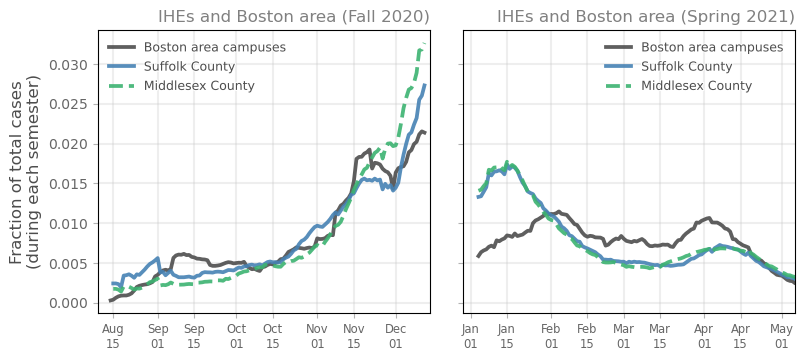

In [22]:
dat_labs1 = ['2020-08-15','2020-09-01','2020-09-15','2020-10-01','2020-10-15',
             '2020-11-01','2020-11-15','2020-12-01','2020-12-15']
dat_labs2 = ['2021-01-01','2021-01-15','2021-02-01','2021-02-15',
             '2021-03-01','2021-03-15','2021-04-01','2021-04-15','2021-05-01']

wid = 14
fig, ax = plt.subplots(1,2,figsize=(9,3.75),dpi=100,sharey=True)
plt.subplots_adjust(wspace=0.1)
fal_date = '2020-12-13'
sch_df = boston_data.loc[boston_data['date']<fal_date].groupby('date').agg(
                            {'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values

suffx = [date_dict[i] for i in ll.loc[(ll['fips']=='25025')&(ll['date']<fal_date)]['date'].values]
suffy = ll.loc[(ll['fips']=='25025')&(ll['date']<fal_date)]['new_cases'].rolling(window=wid).mean().values
middx = [date_dict[i] for i in ll.loc[(ll['fips']=='25017')&(ll['date']<fal_date)]['date'].values]
middy = ll.loc[(ll['fips']=='25017')&(ll['date']<fal_date)]['new_cases'].rolling(window=wid).mean().values

ax[0].plot([date_dict[i] for i in bosdates], allbost/np.nansum(allbost), label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)
ax[0].plot(suffx, suffy/np.nansum(suffy), label='Suffolk County',
        color='steelblue', lw=lw*0.9, alpha=0.9,zorder=1)
ax[0].plot(middx, middy/np.nansum(middy), label='Middlesex County',
        color='mediumseagreen', lw=lw*0.9, alpha=0.9,zorder=1,linestyle='--')
ax[0].set_xticks([date_dict[i] for i in dat_labs1])
ax[0].set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in dat_labs1],fontsize='small')
ax[0].set_xlim(date_dict['2020-08-10']-1, date_dict[fal_date]+1)
ax[0].grid(linewidth=1.5,color='.75',alpha=0.25)
ax[0].tick_params(labelcolor='.4',color='.7')
ax[0].set_ylabel('Fraction of total cases\n(during each semester)',
                 color='.3',fontsize='large')
ax[0].set_title("IHEs and Boston area (Fall 2020)", x=1.0, ha='right', color='.5')
l = ax[0].legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

spr_date = '2020-12-21'
sum_date = '2021-05-05'
sch_df = boston_data.loc[boston_data['date']>spr_date].groupby('date').agg(
                            {'positive_tests':np.nansum}).reset_index()
allbost = sch_df['positive_tests'].rolling(window=wid).mean().values
bosdates = sch_df['date'].values
suffx = [date_dict[i] for i in ll.loc[(ll['fips']=='25025')&(ll['date']>spr_date)]['date'].values]
suffy = ll.loc[(ll['fips']=='25025')&(ll['date']>spr_date)]['new_cases'].rolling(window=wid).mean().values
middx = [date_dict[i] for i in ll.loc[(ll['fips']=='25017')&(ll['date']>spr_date)]['date'].values]
middy = ll.loc[(ll['fips']=='25017')&(ll['date']>spr_date)]['new_cases'].rolling(window=wid).mean().values

ax[1].plot([date_dict[i] for i in bosdates[:-1]], allbost[:-1]/np.nansum(allbost[:-1]),
           label='Boston area campuses',
        color='.3', lw=lw*0.9, alpha=0.9,zorder=1)
ax[1].plot(suffx[:-1], suffy[:-1]/np.nansum(suffy[:-1]), label='Suffolk County',
        color='steelblue', lw=lw*0.9, alpha=0.9,zorder=1)
ax[1].plot(middx[:-1], middy[:-1]/np.nansum(middy[:-1]), label='Middlesex County',
        color='mediumseagreen', lw=lw*0.9, alpha=0.9,zorder=1,linestyle='--')
ax[1].set_xticks([date_dict[i] for i in dat_labs2])
ax[1].set_xticklabels([month_abbrev[i[5:7]]+'\n'+i[8:] for i in dat_labs2],fontsize='small')
ax[1].set_xlim(date_dict['2021-01-01']-3, date_dict[sum_date]+1)
ax[1].grid(linewidth=1.5,color='.75',alpha=0.25)
ax[1].tick_params(labelcolor='.4',color='.7')
ax[1].set_title("IHEs and Boston area (Spring 2021)", x=1.0, ha='right', color='.5')
l = ax[1].legend(fontsize=9,framealpha=0.0,ncol=1,columnspacing=1.5)#,loc=2)
for text in l.get_texts():
    text.set_color('.3')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                           path_effects.Normal()])

plt.savefig('../figs/pngs/university_county_comparison_spr_fall.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/university_county_comparison_spr_fall.pdf', bbox_inches='tight')

plt.show()

________________________

In [33]:
univ = 'Northeastern University'
num_students = 28989
num_employee = 6161
as_of_year = 2019
univ_col = '.35'
univ_abb = school_deets.loc[school_deets['name']==univ,'abbrev'].values[0]
col_vars = ['positive_tests','total_tests']
lab_vars = ['cases','tests']

data_u = boston_data.loc[(boston_data['university']==univ)&\
                         (boston_data['date']<=DATERANGE[date_dict[today]-2])&\
                         (boston_data['date']>='2020-08-17')].copy()

if data_u[col_vars].sum(axis=1).values[-1]==0:
    data_u = boston_data.loc[(boston_data['university']==univ)&\
                             (boston_data['date']<=DATERANGE[date_dict[today]-3])&\
                             (boston_data['date']>='2020-08-17')].copy()    


In [39]:
import json
import urllib.request

all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_names_state = {j:i for i,j in all_state_names.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),#'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

data_names = ['cases','deaths','testing','vaccines','hospitalization']
base_url = 'https://jhucoronavirus.azureedge.net/api/v1/timeseries/us/'
stlist = []

for st_abbrev in [i.upper() for i in all_state_names.keys()]:
    if st_abbrev in ['VI']:
        continue
    dn = data_names[0]
    tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
    with urllib.request.urlopen(tmp_url) as url_i:
        data_i = json.loads(url_i.read().decode())
    st_cases = pd.DataFrame({'date':list(data_i.keys()),
                  'new_%s'%dn: [i["raw_positives"] for i in data_i.values()],
                  'new_%s_7day_avg'%dn: [i['7-day_avg'] for i in data_i.values()]})

    dn = data_names[1]
    tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
    with urllib.request.urlopen(tmp_url) as url_i:
        data_i = json.loads(url_i.read().decode())
    st_deaths = pd.DataFrame({'date':list(data_i.keys()),
                  'new_%s'%dn: [i["raw_positives"] for i in data_i.values()],
                  'new_%s_7day_avg'%dn: [i['7-day_avg'] for i in data_i.values()]})

    dn = data_names[2]
    tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
    with urllib.request.urlopen(tmp_url) as url_i:
        data_i = json.loads(url_i.read().decode())
    st_tests = pd.DataFrame({'date':list(data_i.keys()),
                  'new_%s'%dn: [i["raw_tests"] for i in data_i.values()],
                  'new_%s_7day_avg'%dn: [i['7-day_avg_positivity'] for i in data_i.values()]})

    dn = data_names[3]
    tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
    with urllib.request.urlopen(tmp_url) as url_i:
        data_i = json.loads(url_i.read().decode())
    st_vaccines = pd.DataFrame(data_i)
    st_vaccines = st_vaccines.rename(columns={'doses_admin_daily':'new_vaccines','7_day_avg':'new_vaccines_7day_avg'})

    dn = data_names[4]
    tmp_url = base_url + "%s/%s.json"%(dn, st_abbrev)
    with urllib.request.urlopen(tmp_url) as url_i:
        data_i = json.loads(url_i.read().decode())[0]
    st_hosp = pd.DataFrame({'date':list(data_i.keys()),
                  'new_%s'%dn: [i["inpatient_beds_used_covid"] for i in data_i.values()],
                  'new_%s_7day_avg'%dn: [i['7_day_avg'] for i in data_i.values()]})

    st_df = st_cases.merge(st_deaths, how='left', on='date')
    st_df = st_df.merge(st_tests, how='left', on='date')
    st_df = st_df.merge(st_vaccines, how='left', on='date')
    st_df = st_df.merge(st_hosp, how='left', on='date')
    st_df['state'] = all_state_names[st_abbrev.lower()]
    stlist.append(st_df)

In [61]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
month_abbrev = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
                '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-01-11'

alldates = pd.date_range(start=start, end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values, list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

In [62]:
states_out = []
testin_out = []
for st_i in list(all_names_state.keys()):
    if st_i == 'District of Columbia':
        st_i = 'washington-district-of-columbia'
    
    try:
        st_a = all_names_state[st_i]
        st_i = st_i.lower().replace(' ','-')
        tmp_url = 'https://static01.nyt.com/newsgraphics/2021/coronavirus-tracking/data/pages/us/%s-covid-cases/data.json'%st_i
        with urllib.request.urlopen(tmp_url) as url_i:
            data_i = json.loads(url_i.read().decode())

        drange = DATERANGE[date_dict[data_i['location']['range'][0]]:date_dict[data_i['location']['range'][1]]]
        dfi = pd.DataFrame({"date":drange,
                            "tests_total":data_i['location']['tests_total'][:len(drange)]})
        dfi = dfi.loc[dfi['date']>'2020-12-31'].dropna()
        tot = dfi['tests_total'].max()-dfi['tests_total'].min()

#         if tot-nu_testing<100000:
#             print(st_a,tot,'\t',tot-nu_testing)
        states_out.append(all_state_names[st_a])
        testin_out.append(tot)
            
    except:
        continue
        print('\t',st_i)

In [67]:
nu_testing = data_u.loc[data_u['date']>'2020-12-31']['total_tests'].sum()
states_out.append('Northeastern University')
testin_out.append(nu_testing)

In [141]:
testing_states = pd.DataFrame({'state':states_out,'tests':testin_out}).sort_values('tests')
st_df = pd.concat(stlist)
st_df = st_df.loc[st_df['date']>'2020-12-31'].copy().reset_index().iloc[:,1:]
st_dfg = st_df.groupby('state').agg({'new_testing':'sum'}).reset_index()
testing_states = testing_states.merge(st_dfg,how='left',on='state')
testing_states.loc[testing_states['state']=='Northeastern University','new_testing'] = 507426.0
testing_states['diff'] = testing_states['new_testing']-testing_states['tests']
tmp = pd.read_csv('https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/testing_data/tests_combined_total_source.csv')
tmp = tmp.loc[~tmp['state'].isna()].copy()
tmp['state'] = [all_state_names[i.lower()] for i in tmp['state']]
testing_states = testing_states.merge(tmp,how='left',on='state')

In [143]:
hhs = pd.read_csv('../data/Untitled spreadsheet - Sheet3.csv')
hhs['state'] = [all_state_names[i.lower()] for i in hhs['state']]
testing_states = testing_states.merge(hhs, how='left',on='state')
testing_states.loc[testing_states['state']=='Northeastern University','tests_hhs'] = 507426.0

In [152]:
testing_states = testing_states[['state', 'tests', 'new_testing', 'tests_hhs']].copy()
testing_states = testing_states.sort_values('tests_hhs')#['diff'].plot()

In [ ]:
ax[0].text(1.05, 1.2, '(%s)'%data_u['url'].unique()[0],
           transform=ax[0].transAxes, ha='center', va='top',fontsize='medium',color='.3')
ax[0].text(1.05, 1.155, 'Approximate full-time population (%i): '%as_of_year+\
           'students: %s; employees: %s'%("{:,}".format(int(num_students)),"{:,}".format(int(num_employee))),
           transform=ax[0].transAxes, ha='center', va='top',fontsize='small',color='.5')


for a in fig.axes:
    l = a.legend(fontsize='medium')#,framealpha=0.2)
    for text in l.get_texts():
        text.set_color('.3')
        text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='w'),
                               path_effects.Normal()])
    l.set_zorder(20)
    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll,fontsize=9.25)
    a.set_xlim(date_dict['2020-08-01']-4, date_dict[today]+2)
    a.grid(linewidth=0.5,color='.75',alpha=0.5)
    a.tick_params(labelcolor='.4',color='.7')


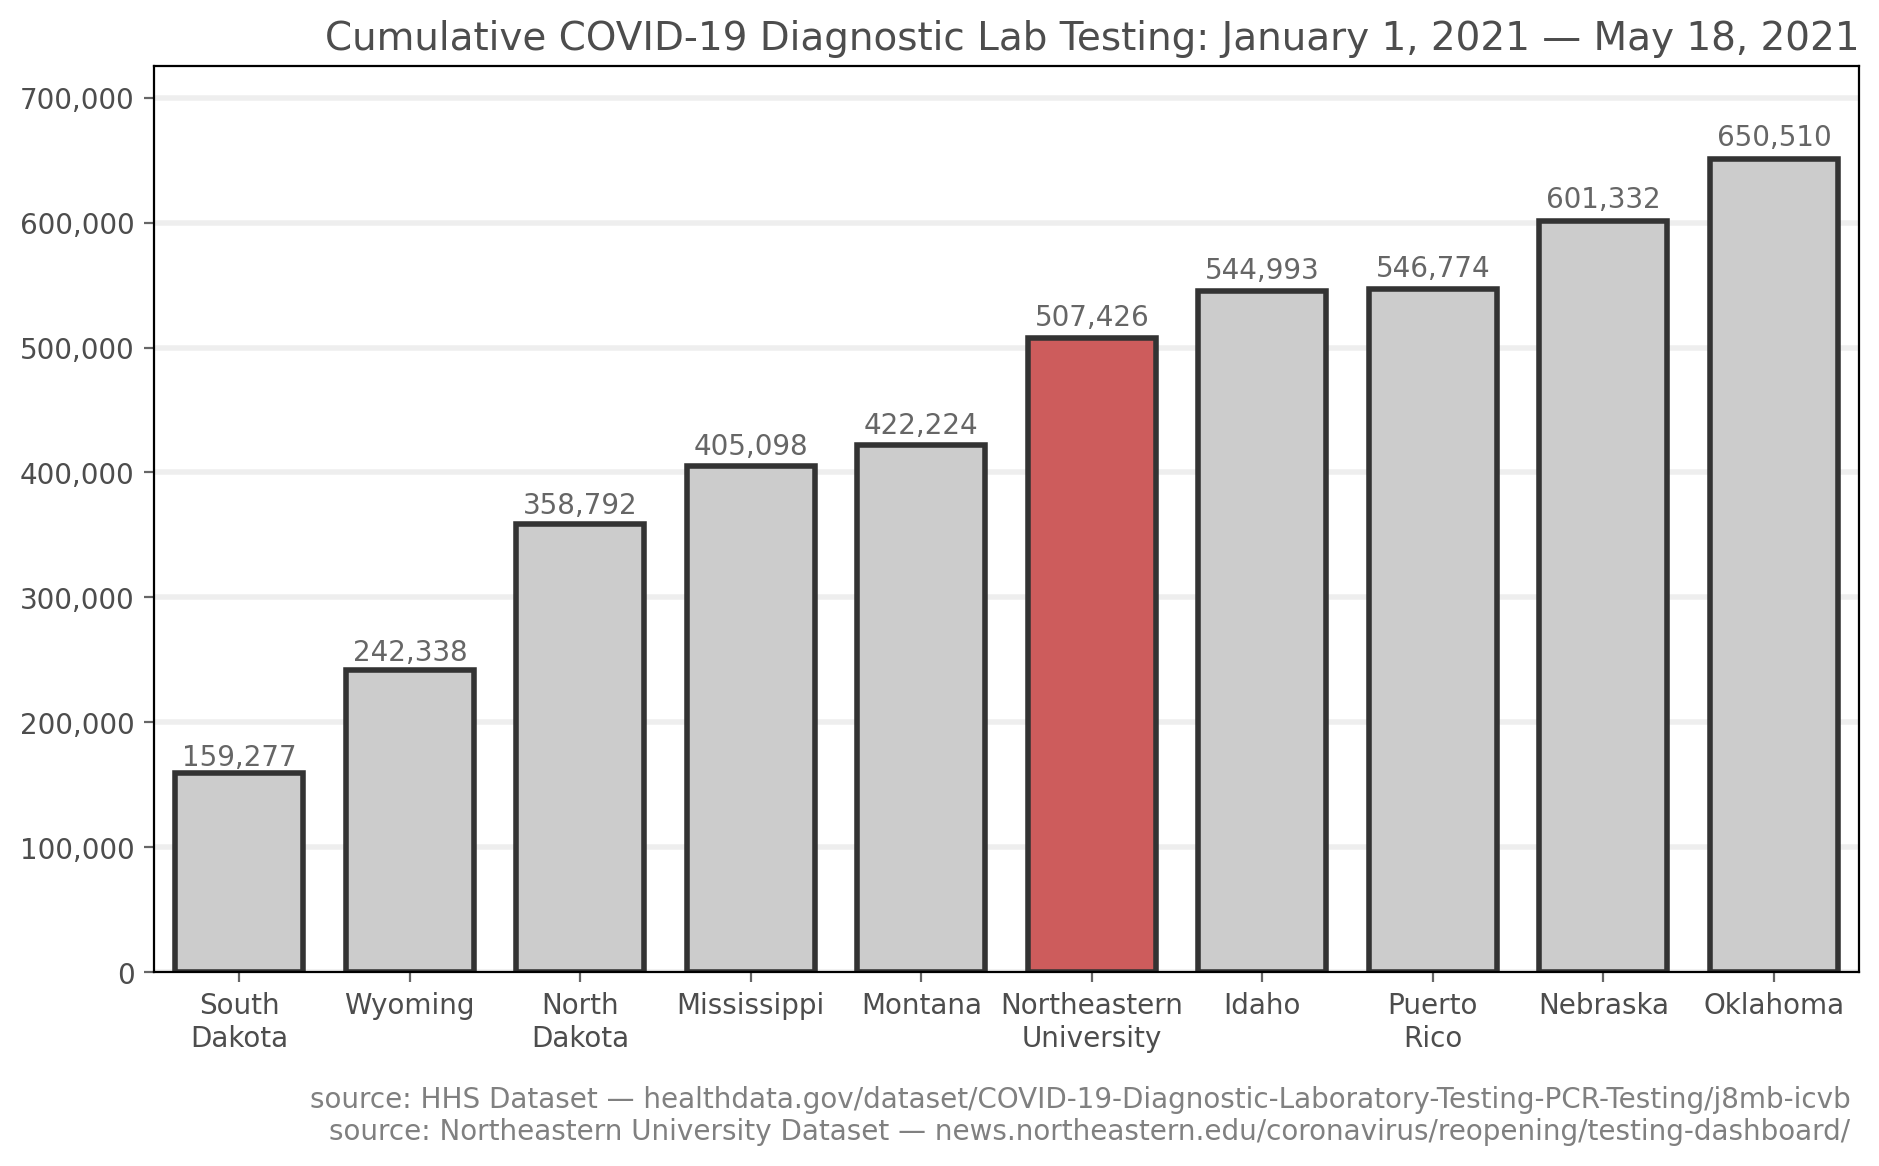

In [234]:
fig, ax = plt.subplots(1,1,figsize=(11,6),dpi=200)
k = 10

ax.bar(list(range(k)),testing_states['tests_hhs'].values[:k],width=0.75,
       color=['.8']*5+['indianred']+['.8']*(k-6),ec='.2',lw=2)

for ix in range(k):
    ax.text(ix,testing_states['tests_hhs'].values[ix]*1.01,"{:,}".format(int(testing_states['tests_hhs'].values[ix])),
           ha='center',va='bottom',color='.4')

ax.set_xticks(list(range(k)))
ax.set_xticklabels([i.replace(' ','\n') for i in testing_states['state'].values[:k]], fontsize=10)
ax.set_xlim(-0.5, k-0.5)
ax.set_yticks(np.arange(0, 800000, 100000))
ax.set_yticklabels(['0','100,000','200,000','300,000','400,000','500,000','600,000','700,000'])#,'800,000'])
ax.set_ylim(0, 725000)
ax.grid(axis='y',linewidth=2,color='.75',alpha=0.25)
ax.tick_params(labelcolor='.3',color='.4')
ax.set_title("Cumulative COVID-19 Diagnostic Lab Testing: January 1, 2021 — May 18, 2021",
             x=1.0, ha='right', color='.3', size=14)
ax.text(0.995,-0.125,
    'source: HHS Dataset — healthdata.gov/dataset/COVID-19-Diagnostic-Laboratory-Testing-PCR-Testing/j8mb-icvb\n'+\
    'source: Northeastern University Dataset — news.northeastern.edu/coronavirus/reopening/testing-dashboard/',
        color='.5', va='top', ha='right', transform=ax.transAxes)

plt.savefig('../figs/pngs/northeastern_vs_states_testing.png', dpi=425, bbox_inches='tight')
plt.savefig('../figs/pdfs/northeastern_vs_states_testing.pdf', bbox_inches='tight')

plt.show()